# RF4 Ballot Box Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from rf4_calcs_audit import parse_payload, determine_results

warnings.filterwarnings("ignore")

## Settings and data pre-processing

In [2]:
# Color definitions
COLOR1 = "#FF0420"
COLOR2 = "#FF6969"
COLOR3 = "#FFCCDD"

# Font size definitions
FONT_SIZE = 15
TITLE_SIZE = 20
SUB_SIZE = 11

# Matplotlib configuration
plt.rcParams.update({
    'figure.figsize': [10, 5],
    'figure.dpi': 300,
    'figure.facecolor': 'white',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'font.family': 'Arial',
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': SUB_SIZE,
    'legend.title_fontsize': SUB_SIZE,
    'figure.titlesize': TITLE_SIZE,
    'figure.titleweight': 'bold',
})

In [3]:
# Load and arrange voting data
VOTES = pd.read_csv('data/private/Voting data export final.csv')['Payload'].apply(parse_payload)
allocations = [v['allocations'] for v in VOTES]
DF_VOTES = pd.DataFrame(allocations) / 100
METRIC_IDS = DF_VOTES.mean().sort_values(ascending=False).index
os_multiply = [v['os_multiplier'] for v in VOTES]
DF_VOTES['os_multiplier'] = os_multiply
print("Total votes:", len(DF_VOTES))

Total votes: 108


In [4]:
# Add metrics to groups
METRIC_GROUPS = {
    'gas_fees': [
        'log_gas_fees',
        'gas_fees'
    ],
    'txn_counts': [
        'log_transaction_count',
        'transaction_count'
    ],
    'trusted_txn_counts': [
        'log_trusted_transaction_count', 
        'trusted_transaction_count'
    ],
    'trusted_users': [
        'trusted_daily_active_users',
        'trusted_monthly_active_users',
        'trusted_transaction_count',
        'log_trusted_transaction_count',
        'trusted_transaction_share',
        'trusted_users_onboarded',
        'openrank_trusted_users_count',
        'trusted_recurring_users'
    ],
    'logs': [
        'log_gas_fees',
        'log_transaction_count',
        'log_trusted_transaction_count'
    ],
    'network_growth': [
        'gas_fees',
        'log_gas_fees',
        'transaction_count',
        'log_transaction_count'
    ],
    'network_quality': [
        'trusted_transaction_count',
        'log_trusted_transaction_count',
        'trusted_transaction_share'
    ],
    'user_growth': [
        'daily_active_addresses',
        'monthly_active_addresses',
        'power_user_addresses',
        'recurring_addresses'
    ],
    'user_quality': [
        'trusted_daily_active_users',
        'trusted_monthly_active_users',
        'trusted_recurring_users',
        'trusted_users_onboarded',
        'openrank_trusted_users_count'
    ]
}

In [5]:
# Load pre-round survey results
DF_SURVEY = pd.read_csv('data/private/Impact_Metric_Survey.csv', usecols=[2,3,4,5,6,7,10,11,12])
DF_SURVEY.columns = [
    'user_growth_or_user_quality',
    'onboarding_new_users',
    'retaining_users',
    'engaging_trusted_users',
    'maintaining_high_levels_of_daily_activity',
    'attracting_loyal_power_users', 
    'network_activity_growth_or_quality',
    'generating_blockspace_demand',
    'using_open_source_and_permissive_licenses'
]
GENERAL_PREFS = ['user_growth_or_user_quality', 'network_activity_growth_or_quality']
SPECIFIC_PREFS = [c for c in DF_SURVEY.columns if c not in GENERAL_PREFS]
DF_SURVEY = DF_SURVEY[GENERAL_PREFS+SPECIFIC_PREFS]
DF_SURVEY.dropna(inplace=True)

for pref in GENERAL_PREFS:
    DF_SURVEY[pref] = DF_SURVEY[pref].apply(lambda x: x.split(' ')[0])
    
print("Num surveys:",len(DF_SURVEY))    

Num surveys: 38


## Chart templates

In [6]:
def barchart(lst, title, top_n=100):
    fig, ax = plt.subplots(figsize=(10,2), dpi=144, facecolor='white')
    series = pd.Series(lst).sort_values(ascending=False).head(top_n) / 1000
    series.plot(kind='bar', color=COLOR1, alpha=.5, ax=ax, width=1)
    ax.set_xlim(0,len(series))
    ax.set_xticks([])
    ax.set_ylim(0,500)
    ax.set_yticks([0,100,200,300,400,500])
    ax.set_yticklabels([0,100,200,300,400,"500K+"])
    
    med = series.median()
    ax.axhline(med, color='grey', linestyle='--', lw=1)
    ax.text(s=f"Median: {med:.0f}K OP", x=len(series), y=series.median(), va='bottom', ha='right')    
    ax.set_title(f"{title} - top {top_n} projects\n", loc='left', weight='bold')
    sns.despine()
    
def stripplot(dataframe, subtitle):
    
    vote_weights = (dataframe[METRIC_IDS].fillna(0).mean() * 100).sort_values(ascending=False)
    metric_order = vote_weights.index
    vote_counts = dataframe[metric_order].count()

    unstacked_votes = dataframe[metric_order].unstack().reset_index()
    unstacked_votes.columns = ['metric', 'voter', 'weight']

    fig, ax = plt.subplots(figsize=(10,5), dpi=144)
    sns.stripplot(
        data=unstacked_votes,
        y='metric',
        x='weight',
        hue='weight',
        hue_norm=(0,.2),
        orient='h',
        palette="Reds",
        alpha=.5,
        jitter=0,
        linewidth=0,
        size=8,
        legend=False,
        ax=ax
    )
    ax.grid(color='grey', linestyle='--', linewidth=.5)       
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.tick_params(direction='out', length=0, width=.5, grid_alpha=0.5)
    ax.set_xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
    ax.set_xticklabels(["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"], fontsize=FONT_SIZE)

    yticks = []
    for lbl in ax.get_yticklabels():
        p = lbl.get_text()
        y = lbl.get_position()[1]
        n = vote_counts.get(p)
        w = vote_weights.get(p)
        p = p.replace("_"," ").title()
        p = p.replace("Log", "(Log)")
        txt = f"{n} votes, {w:.0f}% avg"
        ax.text(s=txt, x=1.06, y=y, ha='left', va='center', fontsize=FONT_SIZE)
        yticks.append(p)

    ax.set_yticklabels(yticks, fontsize=FONT_SIZE)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f"Distribution of impact metric weights by ballot - {subtitle} \n", loc='left', fontsize=TITLE_SIZE, weight='bold')    

## 1. High level analysis of votes

5.0

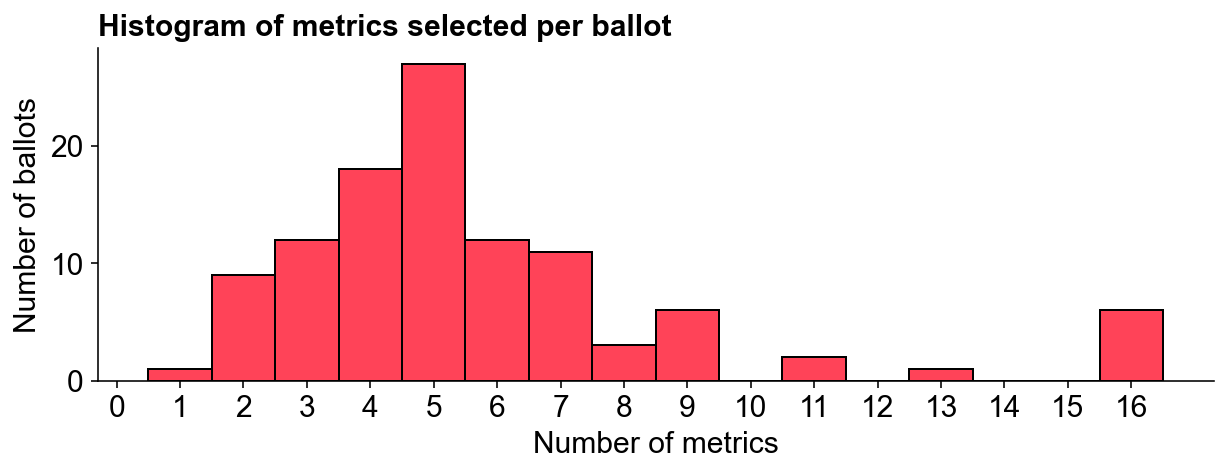

In [7]:
plt.figure(figsize=(10,3), dpi=144)
sns.histplot(DF_VOTES[METRIC_IDS].count(axis=1), bins=list(x+.5 for x in range(0,17)), color='#FF0420')
plt.xticks(list(range(0,17)))
plt.title("Histogram of metrics selected per ballot", loc='left', weight='bold')
plt.ylabel("Number of ballots")
plt.xlabel("Number of metrics")
DF_VOTES[METRIC_IDS].count(axis=1).median()

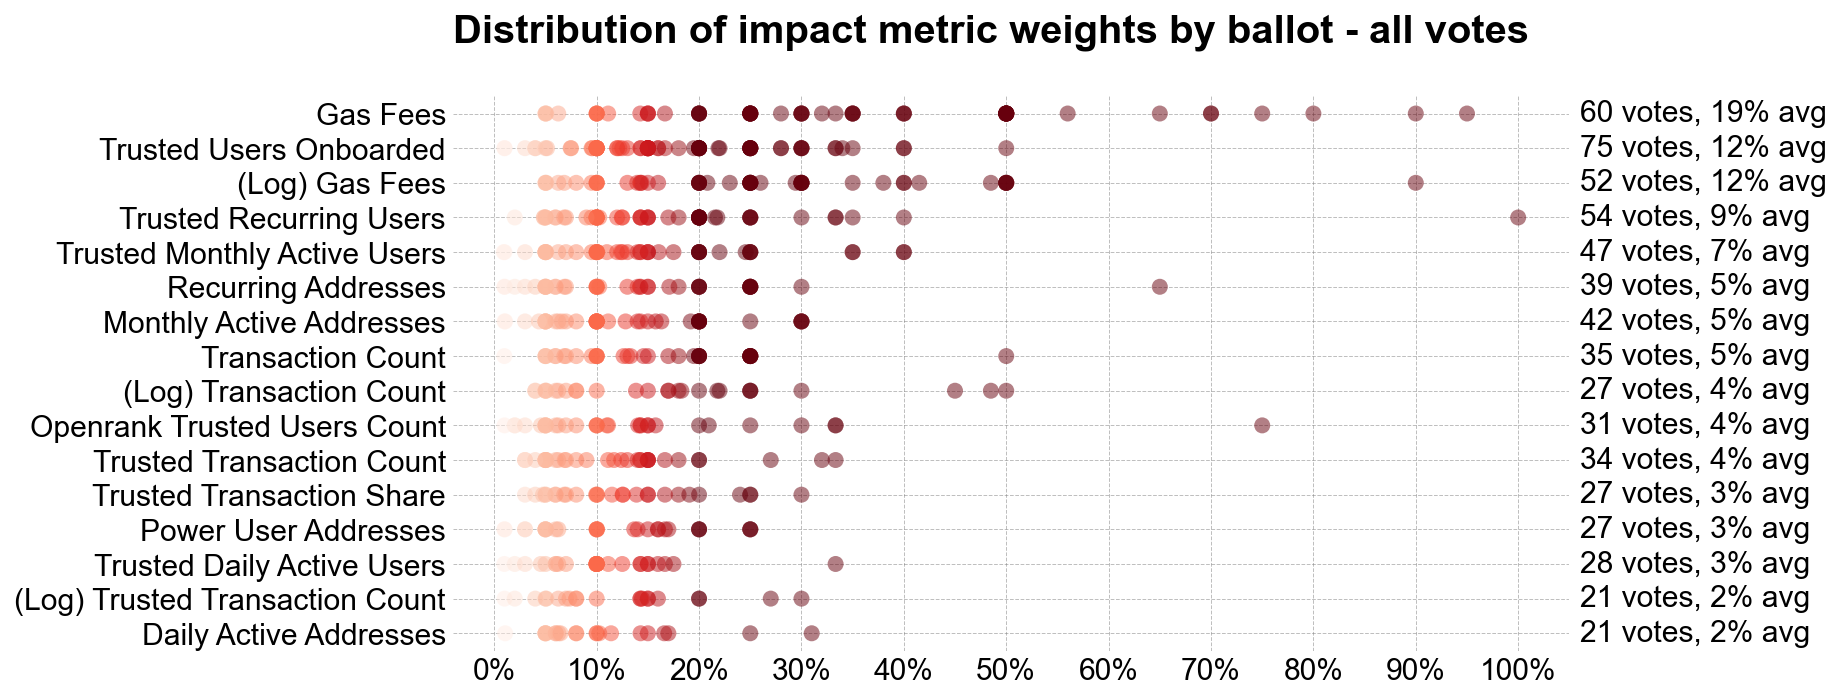

In [8]:
stripplot(DF_VOTES, "all votes")

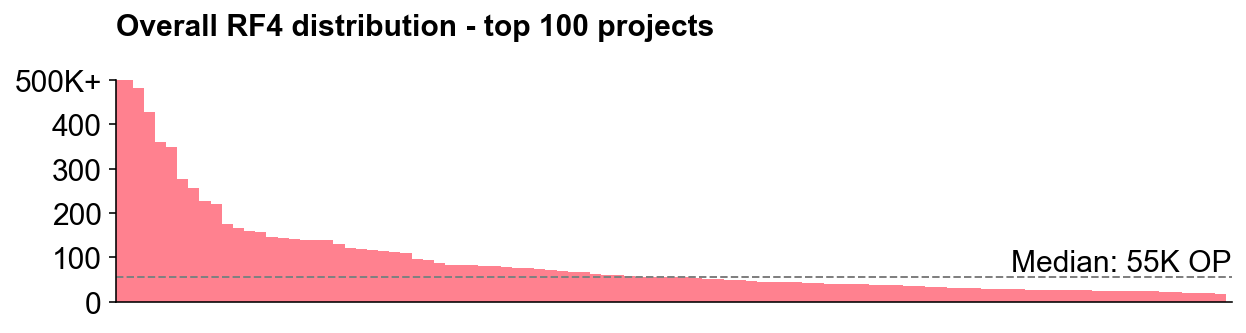

In [9]:
r = determine_results(VOTES)
barchart(r['rf4_allocation'], title='Overall RF4 distribution')

## 2. Analysis by metric category

In [10]:
for grouping, metric_list in METRIC_GROUPS.items():
    filt = DF_VOTES[metric_list].sum(axis=1)
    num_metrics = len(metric_list)
    n = len(filt[filt>0])
    m = filt.mean() * 100
    print(f"{grouping} ({num_metrics} metrics): n={n} ballots, wt={m:.1f}%")

gas_fees (2 metrics): n=94 ballots, wt=31.4%
txn_counts (2 metrics): n=51 ballots, wt=9.5%
trusted_txn_counts (2 metrics): n=42 ballots, wt=6.1%
trusted_users (8 metrics): n=92 ballots, wt=43.7%
logs (3 metrics): n=60 ballots, wt=19.0%
network_growth (4 metrics): n=98 ballots, wt=41.0%
network_quality (3 metrics): n=47 ballots, wt=9.2%
user_growth (4 metrics): n=69 ballots, wt=15.3%
user_quality (5 metrics): n=89 ballots, wt=34.5%


## 3. Compare votes with survey results

In [11]:
print("Num surveys:",len(DF_SURVEY))

Num surveys: 38


In [12]:
for pref in GENERAL_PREFS:
    print(pref)
    print((DF_SURVEY[pref].value_counts()/38).to_dict())
    print()

user_growth_or_user_quality
{'Quality': 0.47368421052631576, 'Both': 0.2894736842105263, 'Growth': 0.23684210526315788}

network_activity_growth_or_quality
{'Both': 0.4473684210526316, 'Quality': 0.39473684210526316, 'Growth': 0.15789473684210525}



Text(0.0, 1.0, 'Comparison of survey preferences vs voting preferences')

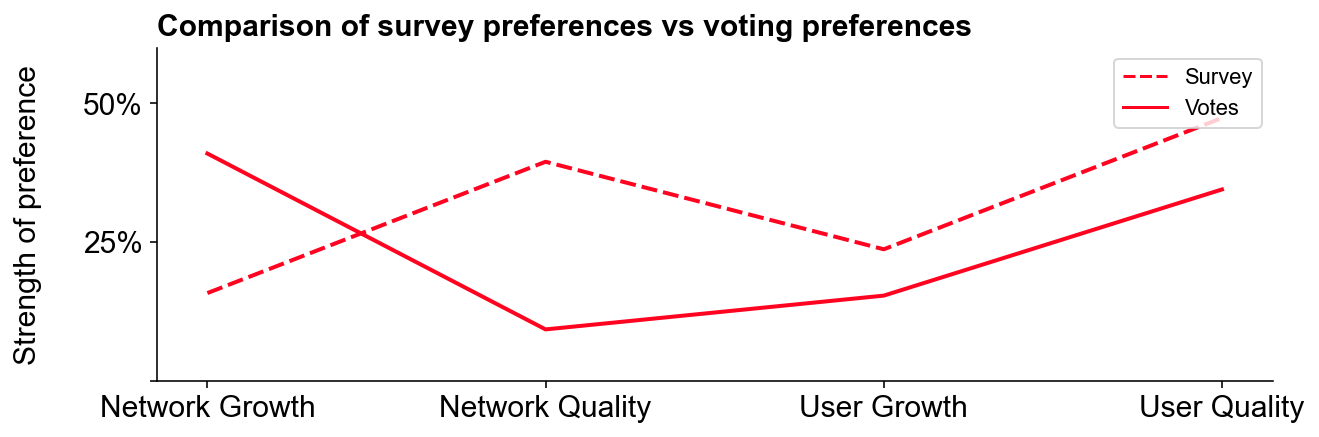

In [13]:
comparison = {
    'Network Growth': {
        'Survey': len(DF_SURVEY[DF_SURVEY['network_activity_growth_or_quality'] == 'Growth']) / len(DF_SURVEY),
        'Votes': DF_VOTES[METRIC_GROUPS['network_growth']].sum(axis=1).mean()
    },
    'Network Quality': {
        'Survey': len(DF_SURVEY[DF_SURVEY['network_activity_growth_or_quality'] == 'Quality']) / len(DF_SURVEY),
        'Votes': DF_VOTES[METRIC_GROUPS['network_quality']].sum(axis=1).mean()
    },
    'User Growth': {
        'Survey': len(DF_SURVEY[DF_SURVEY['user_growth_or_user_quality'] == 'Growth']) / len(DF_SURVEY),
        'Votes': DF_VOTES[METRIC_GROUPS['user_growth']].sum(axis=1).mean()
    },
    'User Quality': {
        'Survey': len(DF_SURVEY[DF_SURVEY['user_growth_or_user_quality'] == 'Quality']) / len(DF_SURVEY),
        'Votes': DF_VOTES[METRIC_GROUPS['user_quality']].sum(axis=1).mean()
    }    
}

fig, ax = plt.subplots(figsize=(10,3), dpi=144)
sns.lineplot(
    data=pd.DataFrame(comparison).T,
    orient='x',
    palette=[COLOR1],
    style_order=['Votes', 'Survey'],
    lw=2,
    ax=ax
)
ax.set_ylim(0,.6)
ax.set_yticks([0,.25,.50])
ax.set_yticklabels(["","25%", "50%"])
ax.legend(loc='upper right')
ax.set_ylabel("Strength of preference\n")
ax.set_title("Comparison of survey preferences vs voting preferences", loc='left', weight='bold')

In [14]:
DF_SURVEY[SPECIFIC_PREFS].mean()

onboarding_new_users                         7.184211
retaining_users                              7.736842
engaging_trusted_users                       6.684211
maintaining_high_levels_of_daily_activity    5.605263
attracting_loyal_power_users                 7.078947
generating_blockspace_demand                 6.947368
using_open_source_and_permissive_licenses    8.157895
dtype: float64

In [15]:
DF_VOTES.mean(axis=0).sort_values(ascending=False)

os_multiplier                    2.109259
gas_fees                         0.345450
log_gas_fees                     0.254575
trusted_users_onboarded          0.179895
log_transaction_count            0.177668
trusted_recurring_users          0.173336
transaction_count                0.156377
trusted_monthly_active_users     0.149853
recurring_addresses              0.142994
openrank_trusted_users_count     0.141259
monthly_active_addresses         0.131373
trusted_transaction_share        0.127307
power_user_addresses             0.119859
log_trusted_transaction_count    0.118864
trusted_transaction_count        0.118805
daily_active_addresses           0.105863
trusted_daily_active_users       0.105853
dtype: float64

In [16]:
len(DF_SURVEY[DF_SURVEY['using_open_source_and_permissive_licenses'] >= 7]) / 38

0.868421052631579

In [17]:
len([x for x in os_multiply if x>1]) / 108

0.7962962962962963

<Axes: >

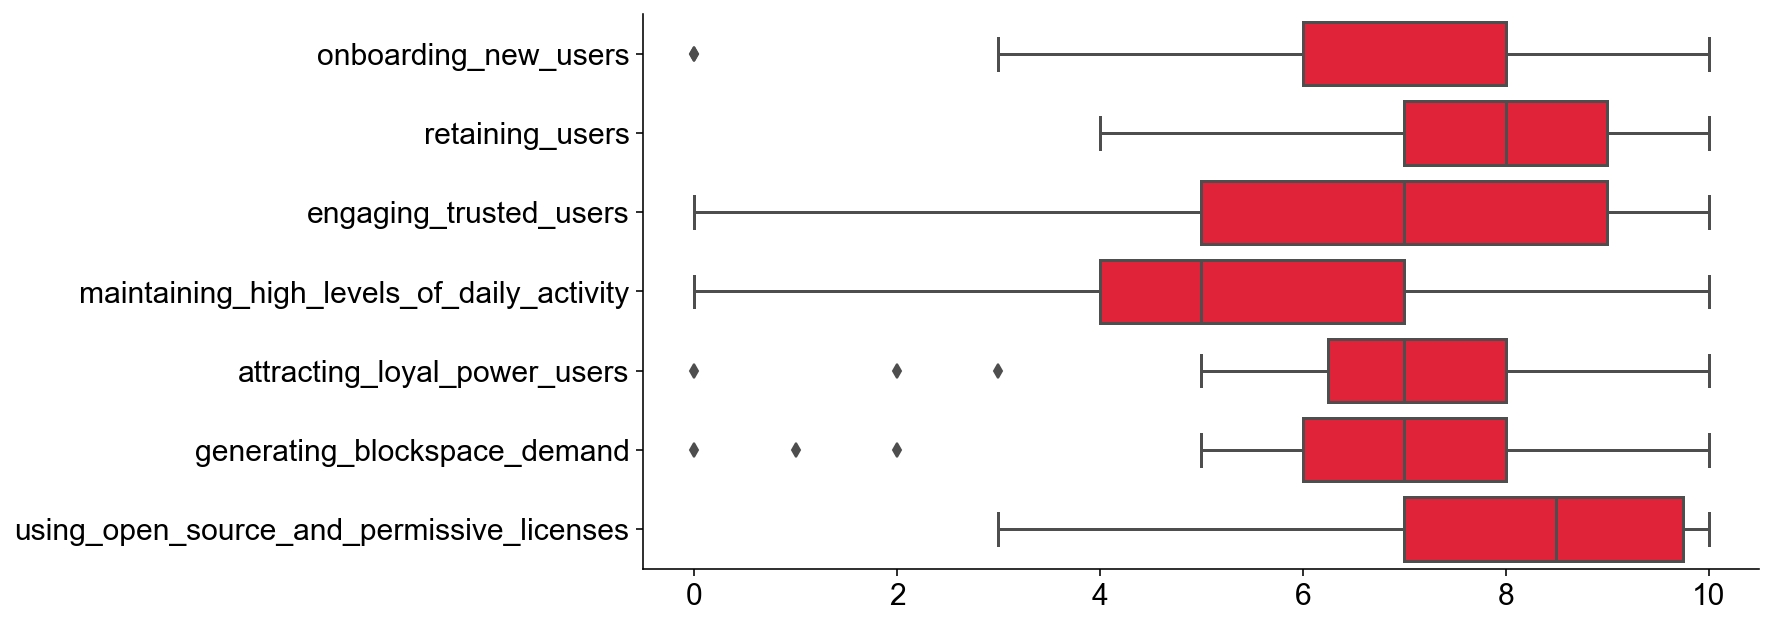

In [18]:
plt.figure(figsize=(10,5), dpi=144)
sns.boxplot(
    data=DF_SURVEY[SPECIFIC_PREFS],
    orient='h',
    color='#FF0420'
)

## 4. Analysis of voting blocs

In [19]:
corr_order = (
    METRIC_GROUPS['network_growth']
    + METRIC_GROUPS['user_growth']
    + METRIC_GROUPS['network_quality']
    + METRIC_GROUPS['user_quality']
)

Text(0.0, 1.0, 'Correlations between impact metrics\n')

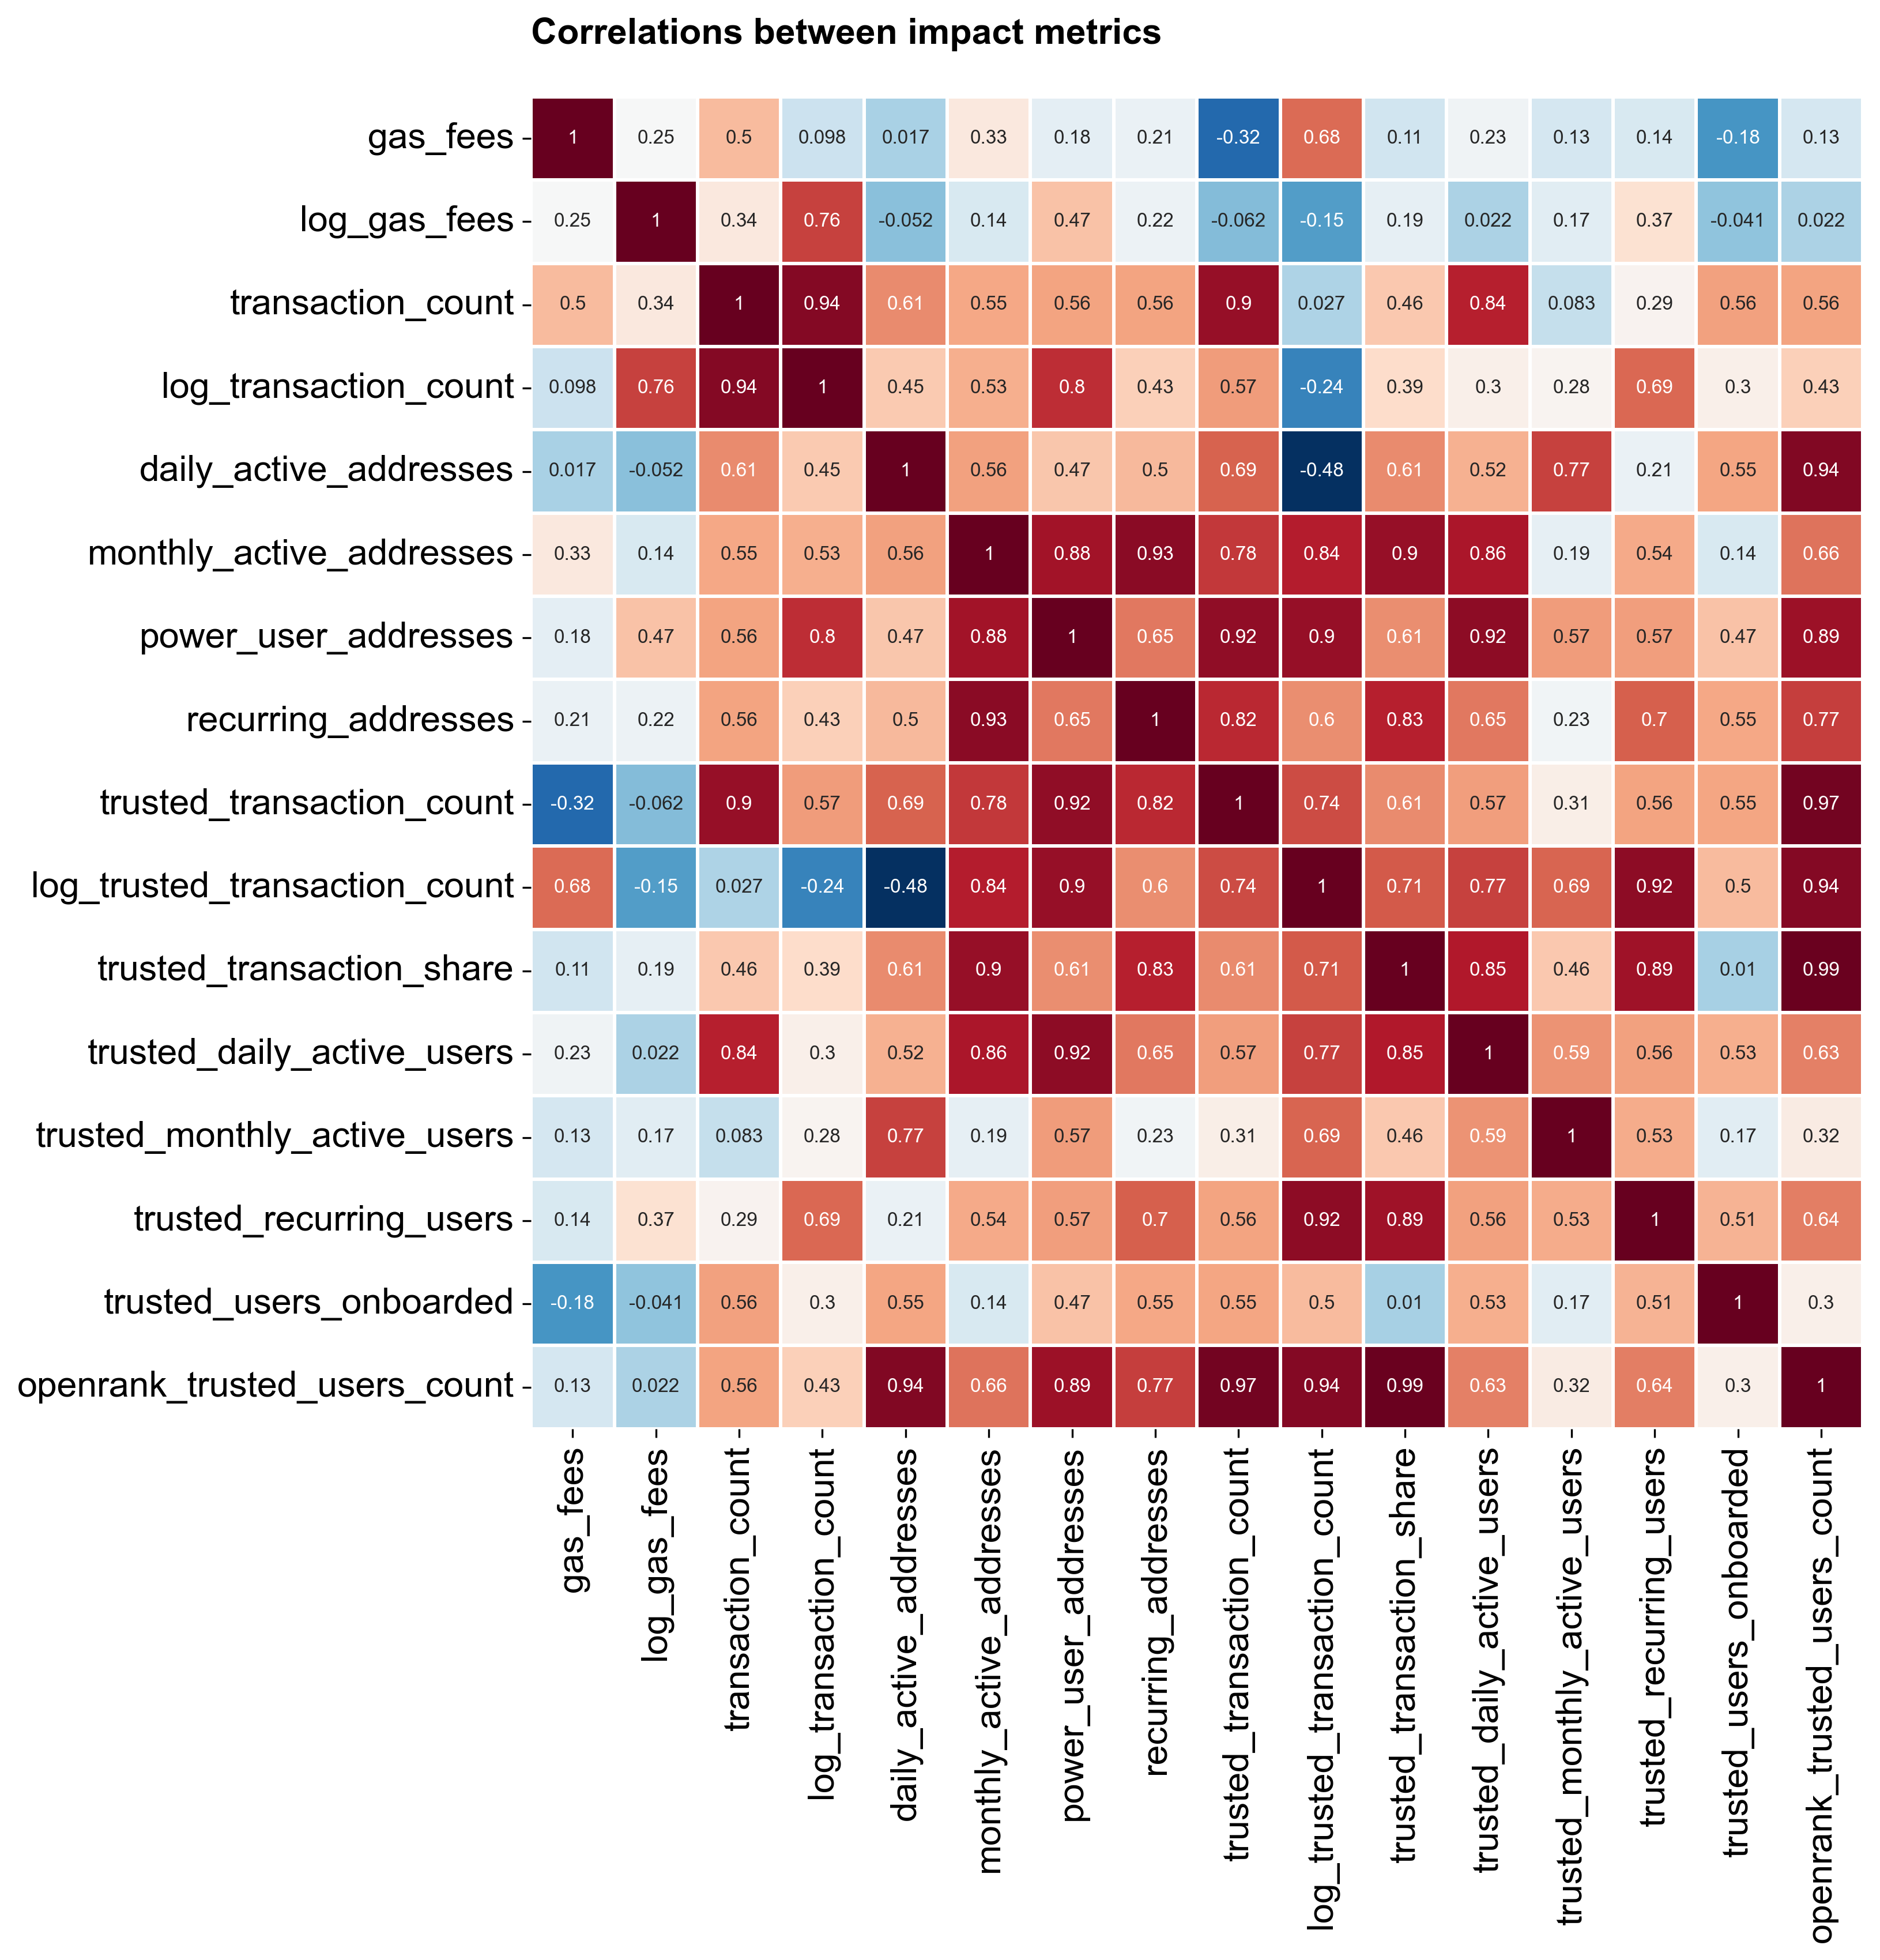

In [20]:
plt.figure(dpi=300, figsize=(10,10))
sns.heatmap(
    DF_VOTES[corr_order].corr(),
    cmap='RdBu_r',
    annot=True,
    annot_kws={'size': 8},
    edgecolor='white',
    linewidth=1,
    square=True,
    cbar=False
)
plt.title("Correlations between impact metrics\n", loc='left', weight='bold')

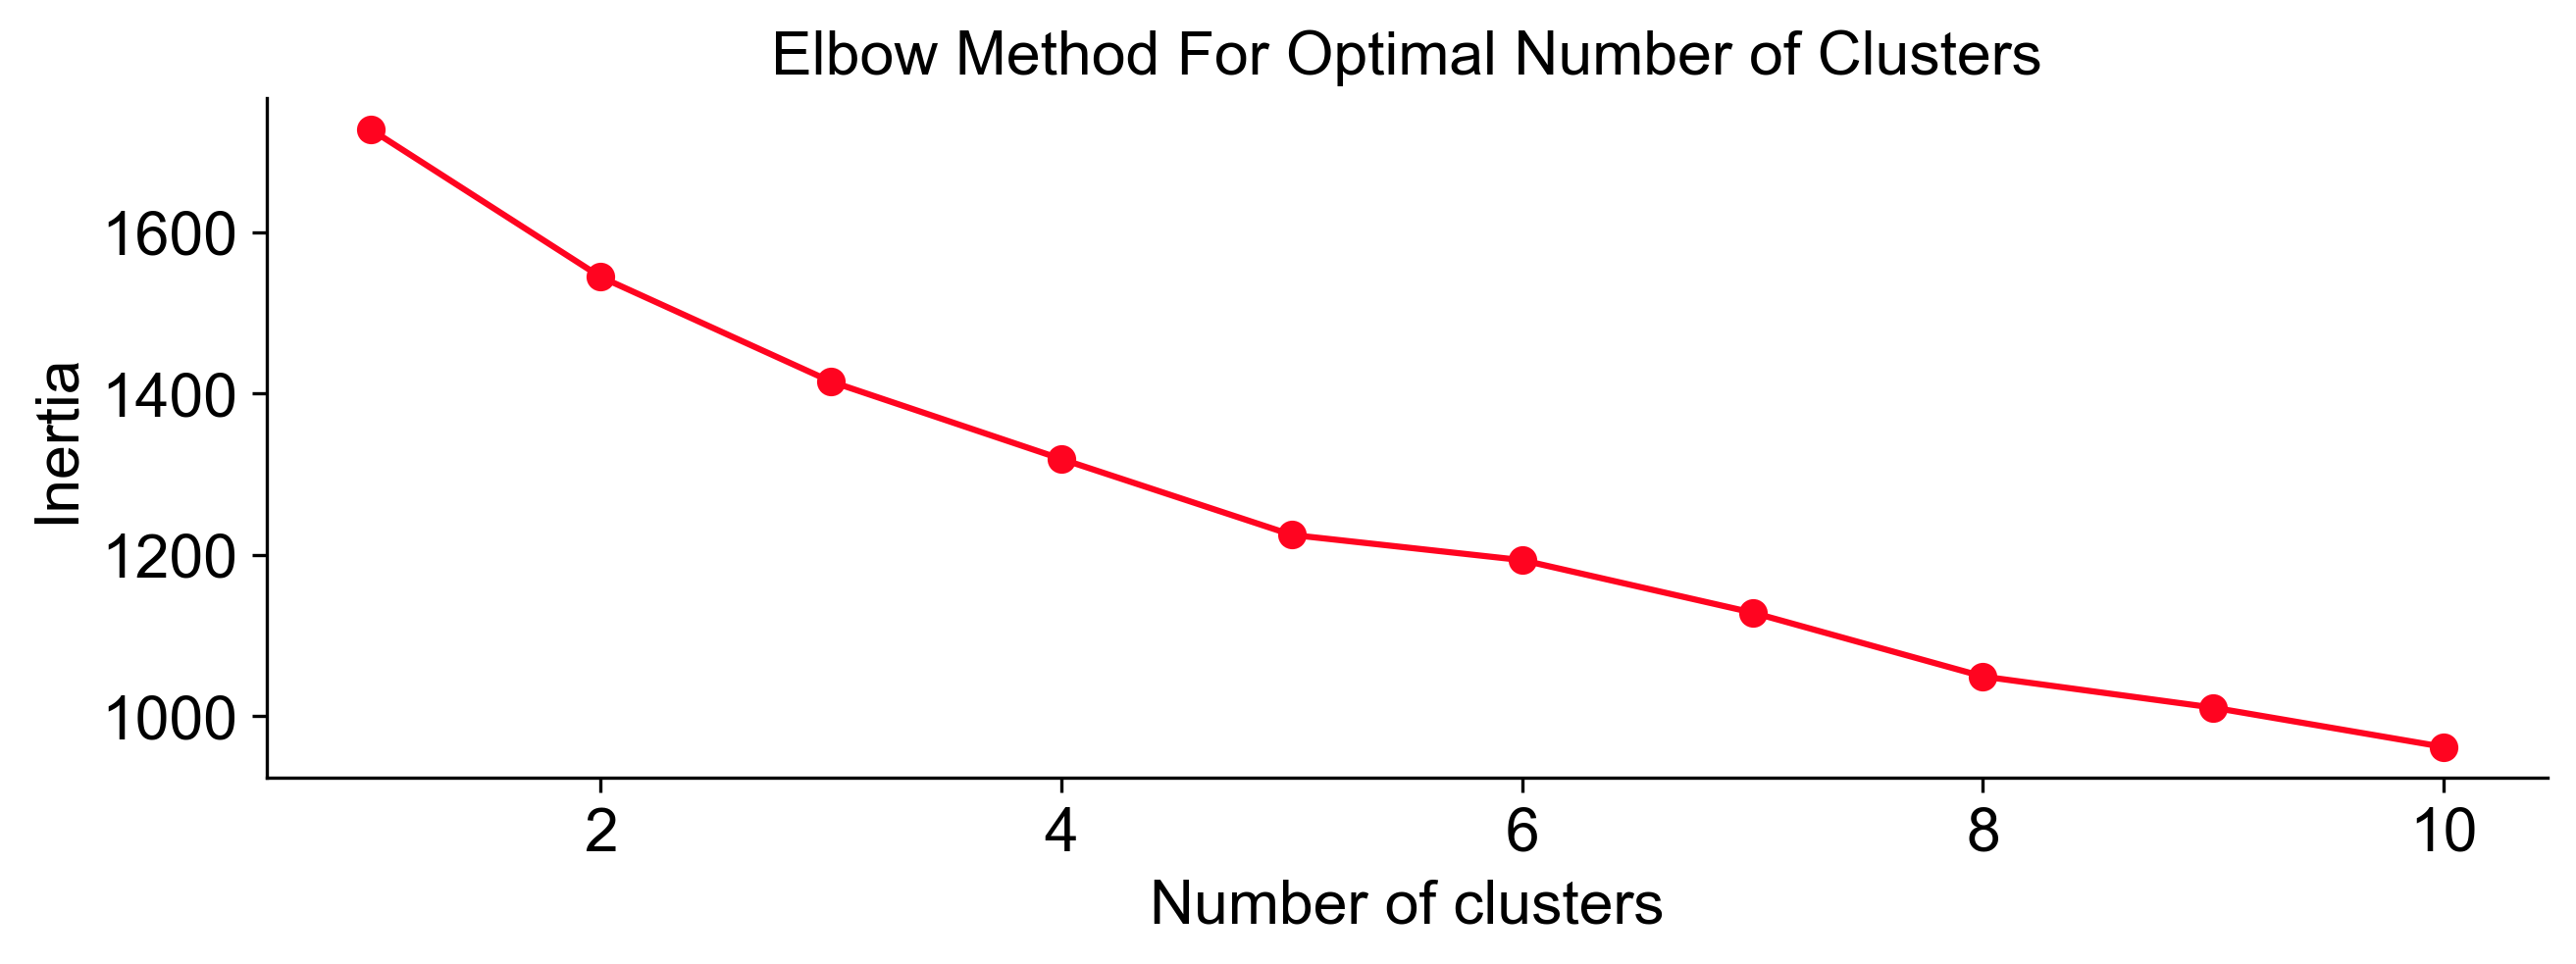

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

votes_df = DF_VOTES[METRIC_IDS].copy().fillna(0)
scaler = StandardScaler()
scaled_votes = scaler.fit_transform(votes_df)

inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init=3)
    kmeans.fit(scaled_votes)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 3))
plt.plot(range(1, 11), inertia, marker='o', color=COLOR1)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3, random_state=42)
votes_df['Cluster'] = kmeans.fit_predict(scaled_votes)

centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=votes_df.columns[:-1])
centroids['Cluster'] = centroids.index
blocs = {
    centroids['gas_fees'].sort_values().index[-1]: "Gas Bloc",
    centroids['trusted_users_onboarded'].sort_values().index[-1]: "Trust Bloc",
}

votes_df['Bloc'] = votes_df['Cluster'].apply(lambda x: blocs.get(x, "Balanced Bloc"))
votes_df['Bloc'].value_counts()

Bloc
Trust Bloc       57
Gas Bloc         28
Balanced Bloc    23
Name: count, dtype: int64

In [23]:
def bloc_distribution(bloc):
    voting_bloc = votes_df[votes_df['Bloc'] == bloc].index
    bloc_results = determine_results(VOTES[voting_bloc])['rf4_allocation'].sort_values()
    barchart(bloc_results, f"'{bloc}' distribution")

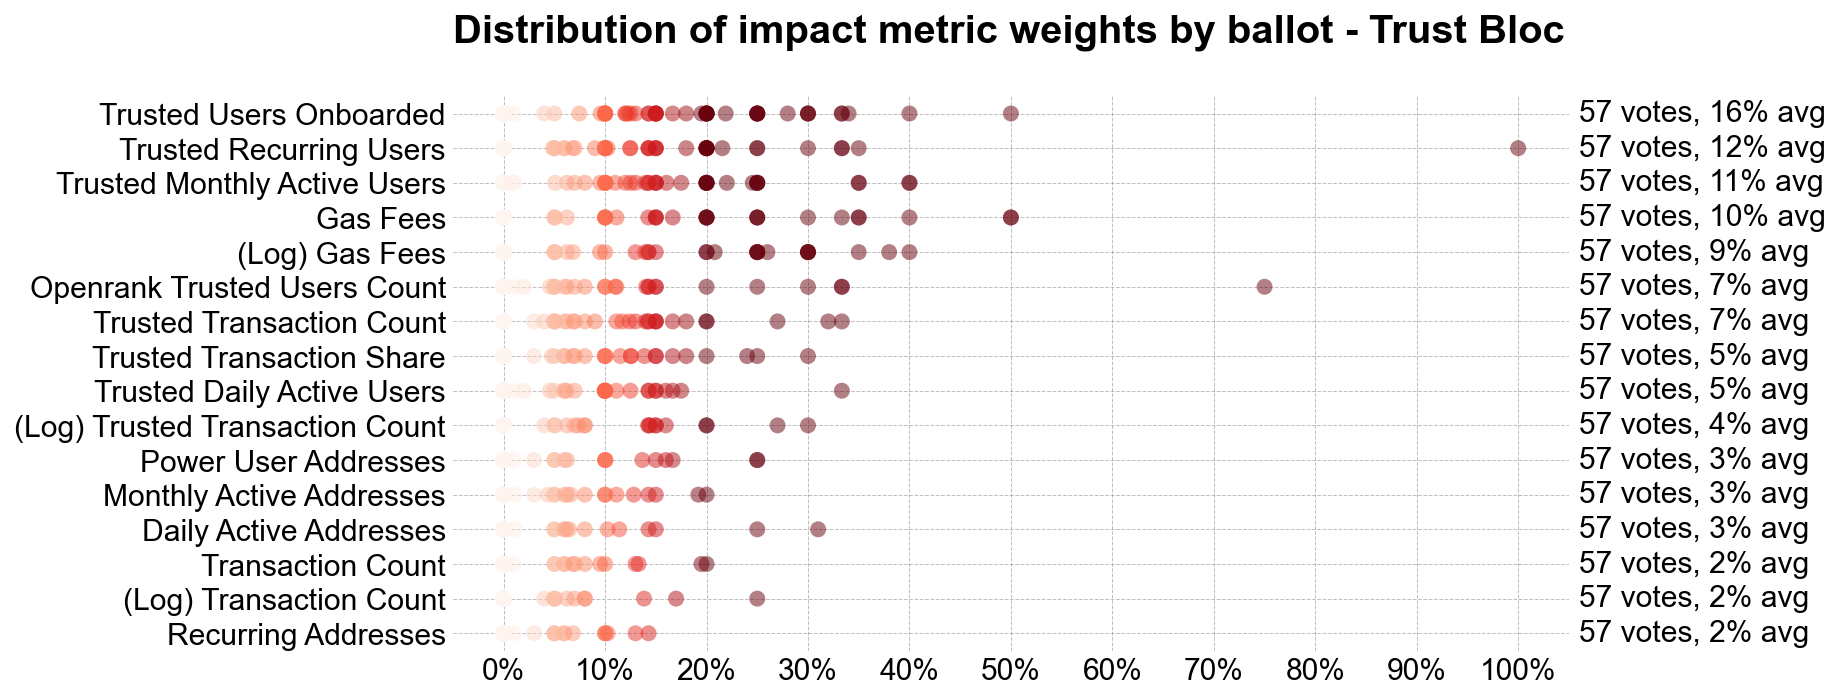

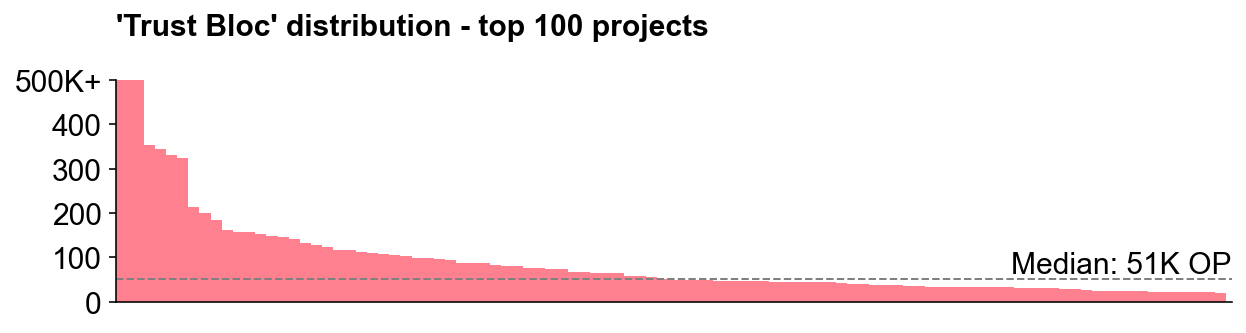

In [24]:
bloc = 'Trust Bloc'
stripplot(votes_df[votes_df['Bloc'] == bloc], subtitle=bloc)
bloc_distribution(bloc)

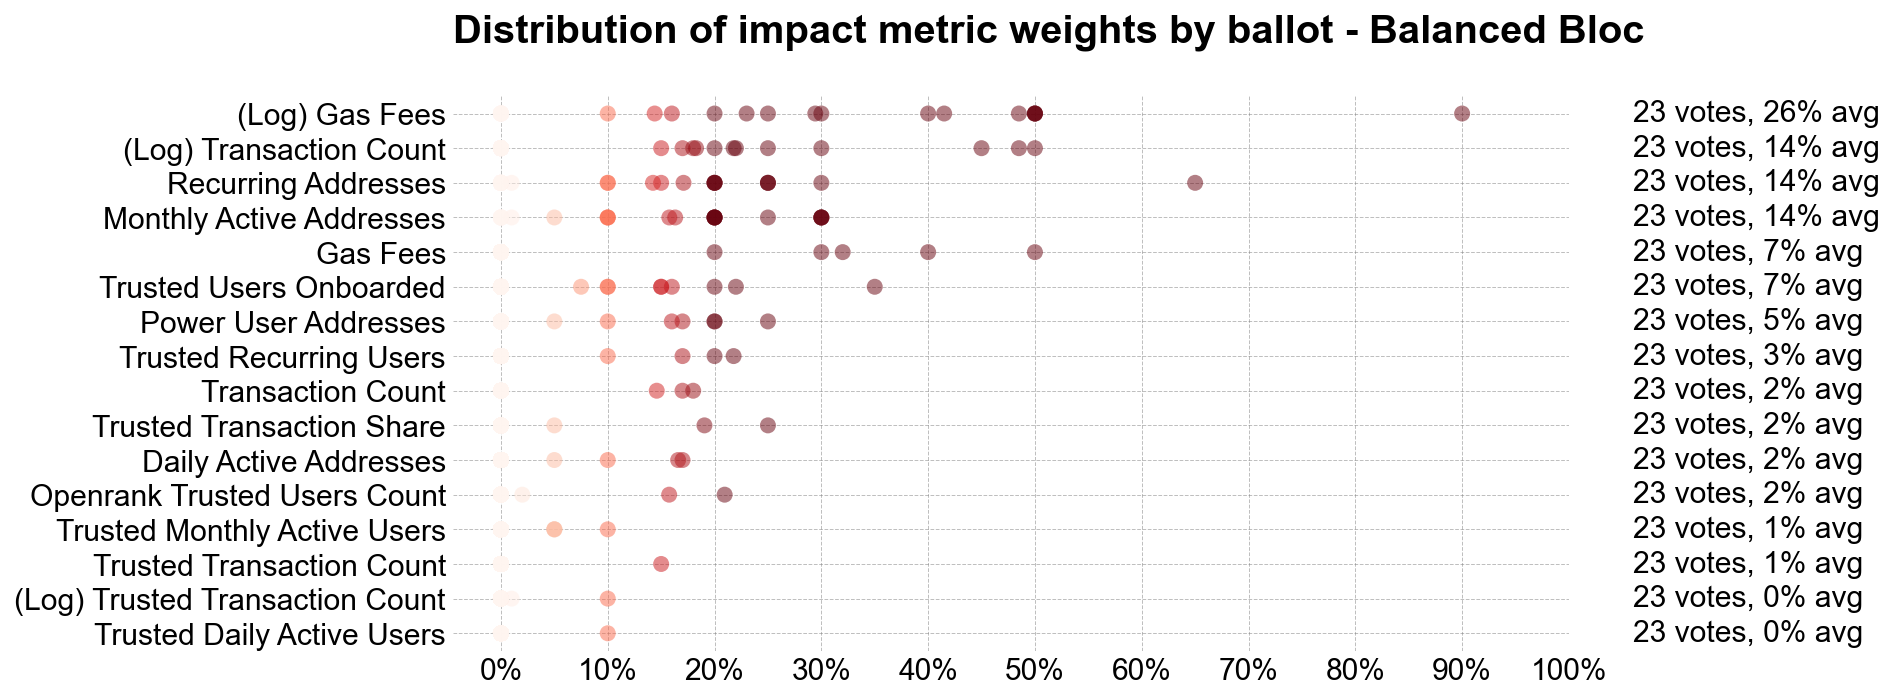

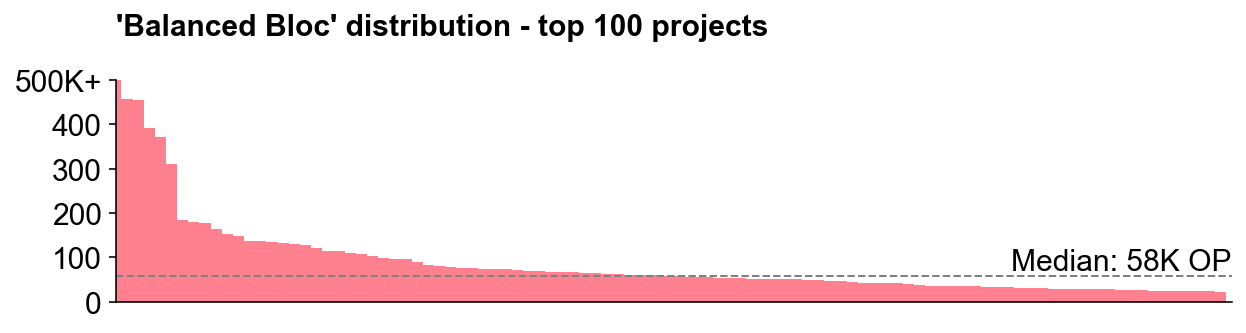

In [25]:
bloc = 'Balanced Bloc'
stripplot(votes_df[votes_df['Bloc'] == bloc], subtitle=bloc)
bloc_distribution(bloc)

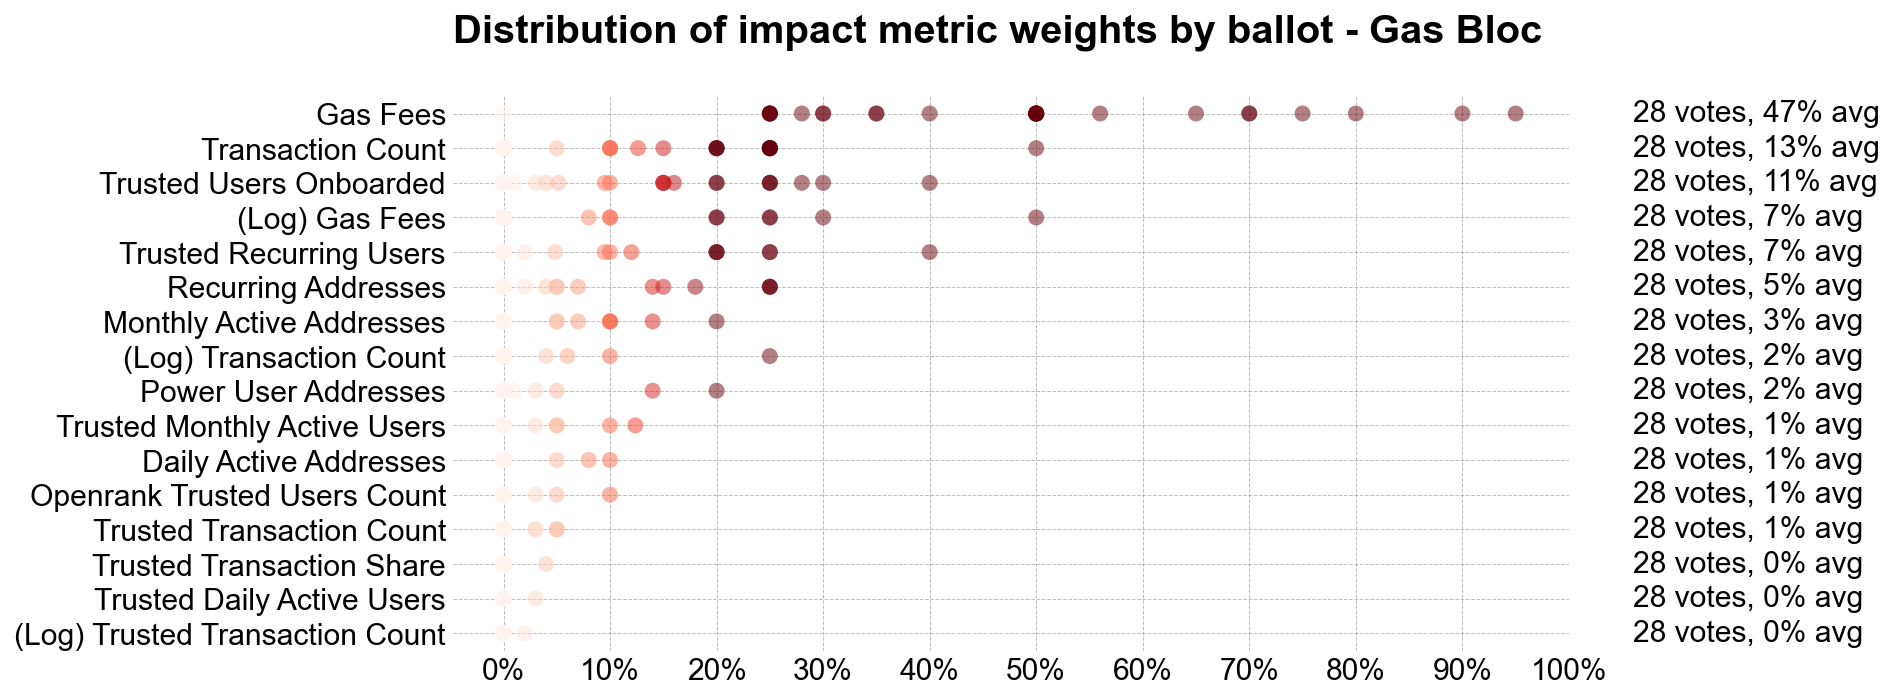

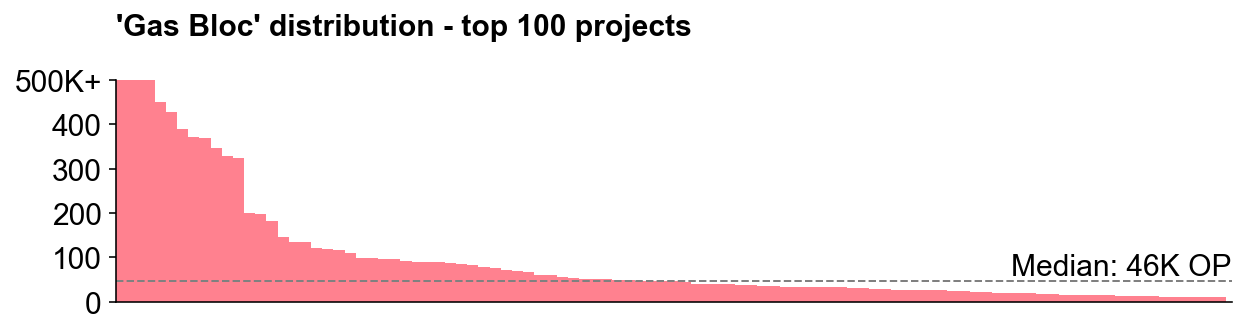

In [26]:
bloc = 'Gas Bloc'
stripplot(votes_df[votes_df['Bloc'] == bloc], subtitle=bloc)
bloc_distribution(bloc)